In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from DataHelper import *
import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [3]:
DATA_PATH = './data'
QUOTATIONS = ['AMZN', 'GOOG', 'AAPL', 'GM', 'TSLA', 'JNJ', 'XOM', 'AAL', 'KO', 'WMT']
#QUOTATIONS = ['AMZN']
FILE_SUFFIX = '.txt'
price_column = 'Close'

df = None
predict_n = 10

for quot in QUOTATIONS:
    #temp_df = pipeline_preprocessing(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n, price_column=price_column)
    temp_df, feature_names = features_pipeline(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n,
                                price_column=price_column, normalize_features=True, base_features_normalize=['Volume'])
    if df is None:
        df = temp_df
    else:
        df = df.append(temp_df)

print(len(df))
df.head()
df = df.dropna()

32624


In [4]:
df.isna().any()

Date               False
Open               False
High               False
Low                False
Close              False
Volume             False
Adjusted           False
Difference         False
PercentageDiff     False
Tendency           False
MA(10)             False
MA(20) - MA(10)    False
RSI(14)            False
GAP                False
RSI_Diff           False
Volume_diff        False
Next               False
MACD               False
MACD_diff          False
MACD_signal        False
dtype: bool

In [5]:
from torch.utils.data import Dataset

class StocksDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.Tensor(data.values)
        self.target = torch.Tensor(target.values)
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
        
    def __len__(self):
        return len(self.data)

y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names
data_columns = ['MACD', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'GAP'] + [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
y = dataset[y_column]

X.head()

,MACD,MACD_diff,RSI(14),PercentageDiff,GAP
34,-0.320112,-0.001694,0.244567,-0.030840,0.121842
35,-0.319641,-0.001775,0.345495,0.007356,0.120791
36,-0.319260,-0.002013,0.367824,-0.014802,0.121550
37,-0.317229,0.000990,0.661671,0.155950,0.113147
38,-0.315829,0.002172,0.619134,0.105387,0.120616


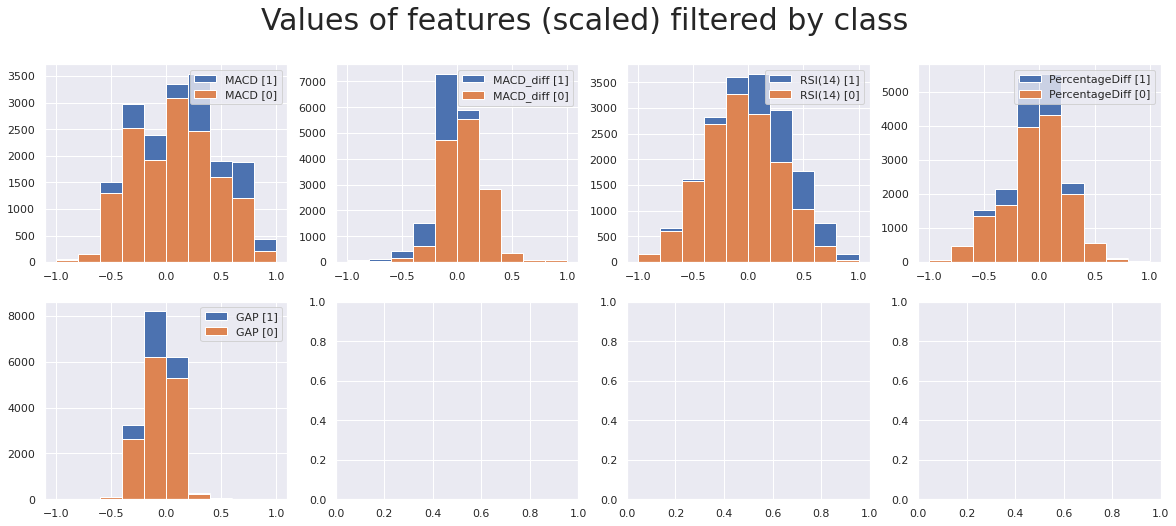

In [6]:
N_COLS = 4
plot_feature_names = data_columns.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in dataset.columns.values:
    plot_feature_names.append('Volume')

# get an array of subplots depending on the number of features, splitted into 3 columns
fig, axs = plt.subplots(int(np.ceil(len(plot_feature_names) / N_COLS)), N_COLS)
fig.suptitle('Values of features (scaled) filtered by class')
for i, feature in enumerate(plot_feature_names):
    sub_df = dataset[[feature, 'Next']]
    #print(f"[{i}] : {i // N_COLS}, {i % N_COLS}")
    for target_c in y.value_counts().to_dict().keys():
        filtered_df = sub_df[sub_df['Next'] == target_c]
        # plot the histogram with the 
        axs[i // N_COLS, i % N_COLS].hist(filtered_df[feature], label=f"{feature} [{target_c}]")
        axs[i // N_COLS, i % N_COLS].legend(loc='best')


plt.show()

In [7]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 22836, test_size : 9788


In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

### Model

In [9]:
import torch.nn as nn

class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            #nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            #nn.Softmax(1),
        )
        
        
    def forward(self, x):
        out = self.classifier(x)
        #print(out)
        return out
    
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import *

def create_model(lr, input_dim):
    model = LinearModel(input_dim=input_dim)
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    return model, optimizer, loss_fn

lr = 2e-5

model, optimizer, loss_fn = create_model(lr, input_dim = len(X.columns))
model = model.to(device)
train(train_dataloader, model, n_epochs=20, optimizer=optimizer, loss_fn=loss_fn, device=device)

Epoch 1, loss: 0.680156409740448, accuracy : 53.80
Epoch 2, loss: 0.6738117337226868, accuracy : 56.30
Epoch 3, loss: 0.6302787065505981, accuracy : 59.51
Epoch 4, loss: 0.6445947885513306, accuracy : 60.35
Epoch 5, loss: 0.5985746383666992, accuracy : 60.84
Epoch 6, loss: 0.6274466514587402, accuracy : 60.97
Epoch 7, loss: 0.5874966382980347, accuracy : 61.15
Epoch 8, loss: 0.682612419128418, accuracy : 61.21
Epoch 9, loss: 0.629254937171936, accuracy : 61.26
Epoch 10, loss: 0.6537576913833618, accuracy : 61.20
Epoch 11, loss: 0.7643654942512512, accuracy : 61.32
Epoch 12, loss: 0.6162506937980652, accuracy : 61.49
Epoch 13, loss: 0.8401435017585754, accuracy : 61.46
Epoch 14, loss: 0.5038334727287292, accuracy : 61.74
Epoch 15, loss: 0.7026171088218689, accuracy : 61.74
Epoch 16, loss: 0.6064559817314148, accuracy : 61.89
Epoch 17, loss: 0.7655959129333496, accuracy : 62.01
Epoch 18, loss: 0.5521678328514099, accuracy : 61.88
Epoch 19, loss: 0.6419678926467896, accuracy : 62.02
Epoch

In [10]:
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import *

predictions, labels = predict(test_dataloader, model, device)

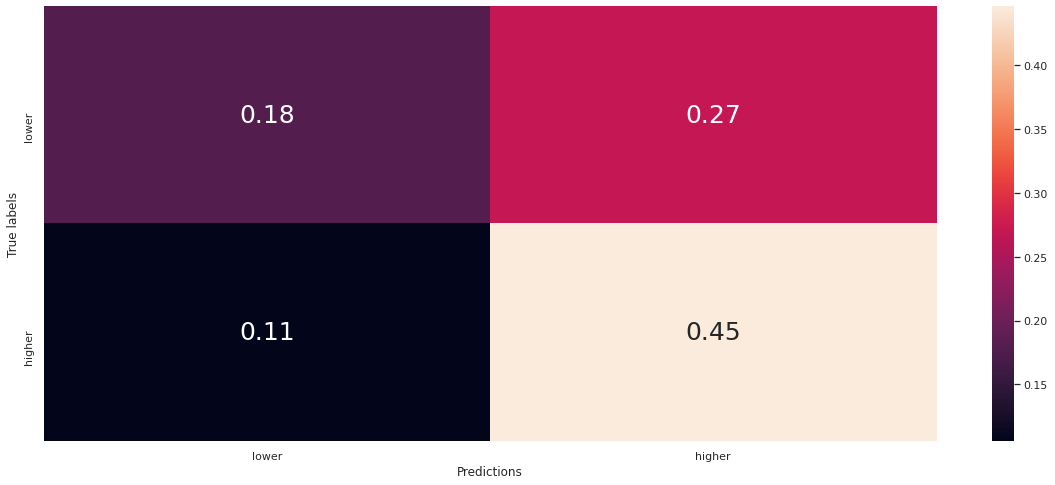

In [11]:
from sklearn.metrics import confusion_matrix


class_labels = ['lower', 'higher']

cf_matrix = confusion_matrix(y_true=labels, y_pred=predictions, normalize='all')
predict_df = pd.DataFrame(cf_matrix, index = [c for c in class_labels], columns = [c for c in class_labels])
ax = sns.heatmap(predict_df, annot=True)
ax.set_xlabel('Predictions')
ax.set_ylabel('True labels')
plt.show()